In [1]:
import sys

from src.dataset import X_TIME, TIME_STEP
from src.gauss_hist import get_gauss_stats
from src.models import optimal_model_builder_ch_2_11

PWD = '../../..'
sys.path.append(PWD)

import pickle
import numpy as np

import tensorflow as tf

tf.get_logger().setLevel('ERROR')
from tensorflow.python.framework.errors_impl import NotFoundError

from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

from src.cfd import CFD, find_optimal_cfd_threshold
from src.network_utils import train_model as _base_train_model, plot_difference_hist, plot_history, compare_results, \
    gaussian_kernel

In [2]:
N_JOBS = 16

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'

PRINT_PCOV = False

N_BASELINE = 8

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 3000
BATCH_SIZE = 2048
LOSS_WEIGHT = 1000

CFD_THRESHOLD_SPACE = np.arange(0.12, 0.25, 0.005)
OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_train_data.pkl'

TRAIN_TEST_SPLIT_RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)

# Utils

In [4]:
def model_predict(model: tf.keras.Model, X: np.ndarray):
    Y_heatmap_pred = model.predict(X, batch_size=4096)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    return y_pred

In [5]:
def train_model(model, name, X_train, y_train, X_val, y_val, lr=LR, train=False, n_epochs=N_EPOCHS, verbose=0,
                batch_size=BATCH_SIZE, lr_patience=10, es_patience=60, es_min_delta=ES_MIN_DELTA,
                loss_weights=LOSS_WEIGHT):
    return _base_train_model(model, name, 'many_channels_tests/trained_separately', X_train, y_train, X_val, y_val, lr,
                             train, n_epochs, verbose, batch_size, lr_patience, es_patience, es_min_delta, loss_weights,
                             root=PWD + '/data')

# Find optimal CFD thresholds (use only the training set)

In [6]:
# optimal_cfd_thresholds = {}
# for plane, channel in sorted(dataset.keys()):
#     print(f'Processing p={plane}, ch={channel}...')
#     all_X, all_y = dataset[(plane, channel)][0], dataset[(plane, channel)][1]
#     X_train, _, y_train, _ = train_test_split(all_X, all_y, test_size=0.25, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)
#
#     optimal_cfd_threshold = find_optimal_cfd_threshold(CFD_THRESHOLD_SPACE, N_BASELINE, X_train, y_train, X_TIME, n_jobs=N_JOBS, plot=False)
#     optimal_cfd_thresholds[(plane, channel)] = optimal_cfd_threshold
#
# with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'wb') as file:
#     pickle.dump(optimal_cfd_thresholds, file)

In [7]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.180
(1, 11): 0.185
(2,  2): 0.220
(2, 11): 0.145
(3,  2): 0.130
(3, 11): 0.175


# Test

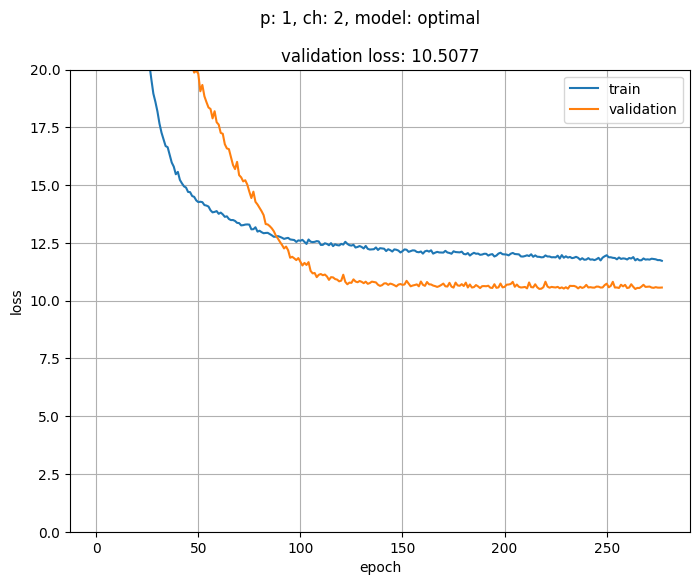

1/1 [==============================] - 2s 2s/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


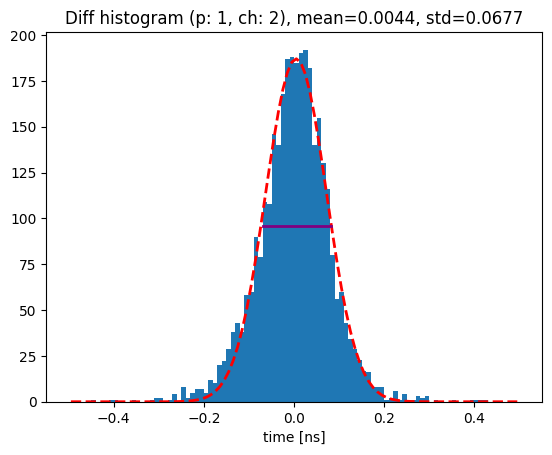

       CFD: 76.08 ps
   optimal: 67.70 ps (improvement: 11.01 %)


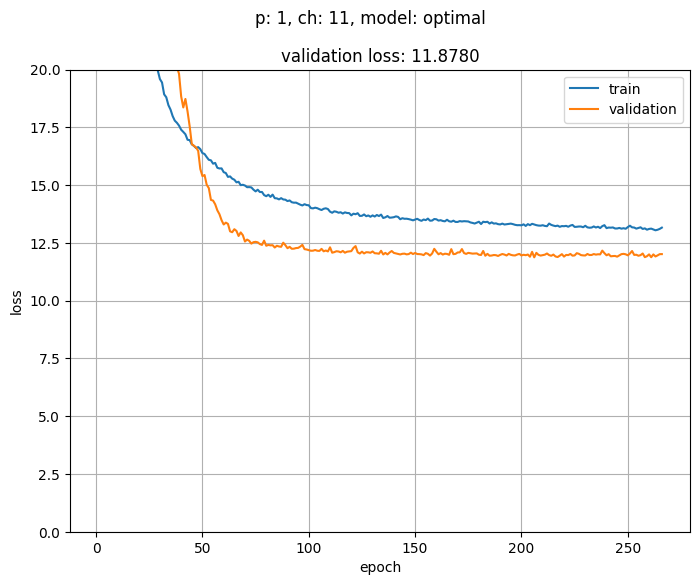

2/2 [==============================] - 0s 26ms/step


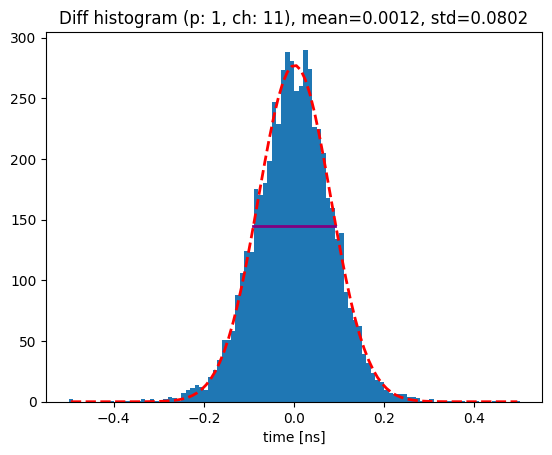

       CFD: 88.03 ps
   optimal: 80.22 ps (improvement: 8.87 %)


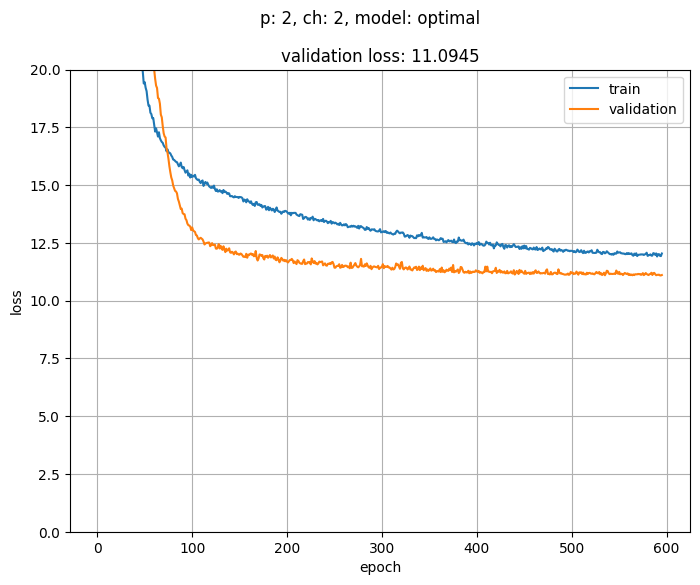

1/1 [==============================] - 0s 153ms/step


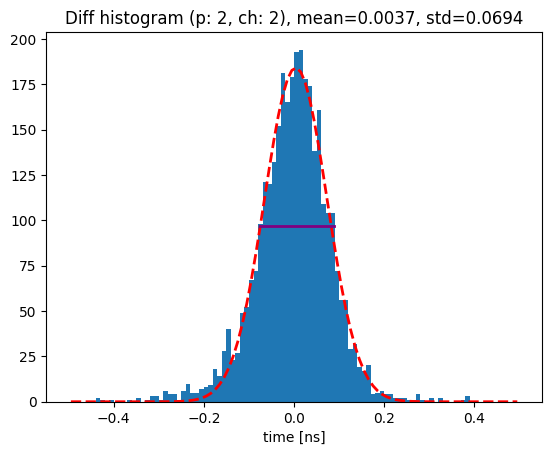

       CFD: 80.13 ps
   optimal: 69.42 ps (improvement: 13.36 %)


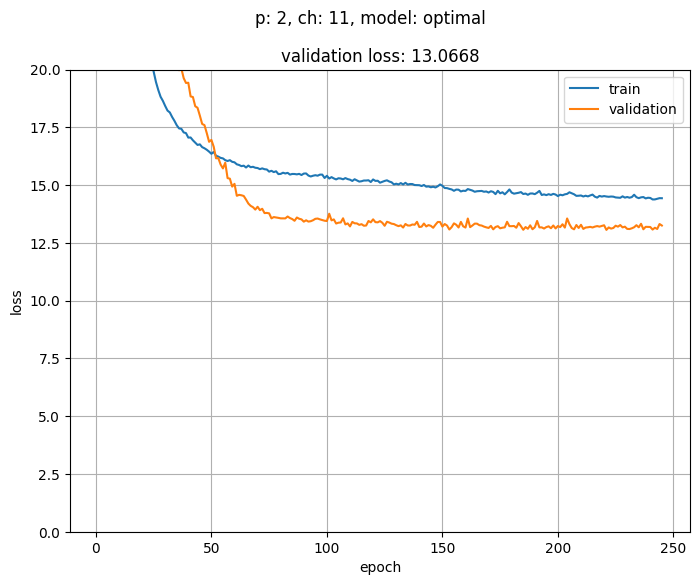

2/2 [==============================] - 0s 109ms/step


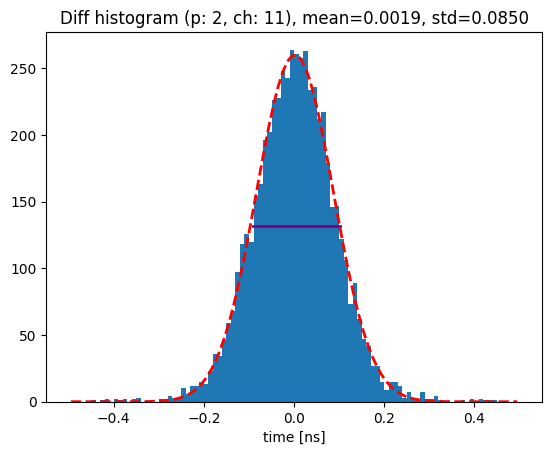

       CFD: 90.39 ps
   optimal: 85.02 ps (improvement: 5.94 %)


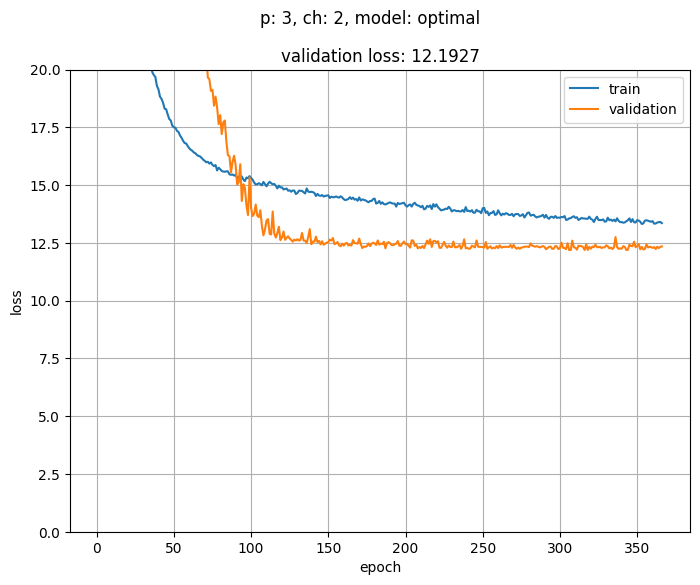

1/1 [==============================] - 0s 216ms/step


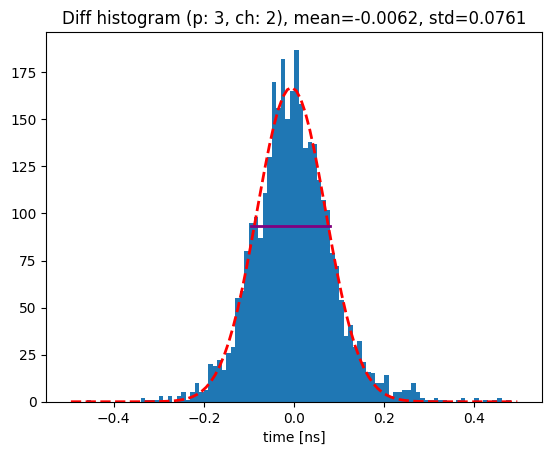

       CFD: 86.67 ps
   optimal: 76.14 ps (improvement: 12.14 %)


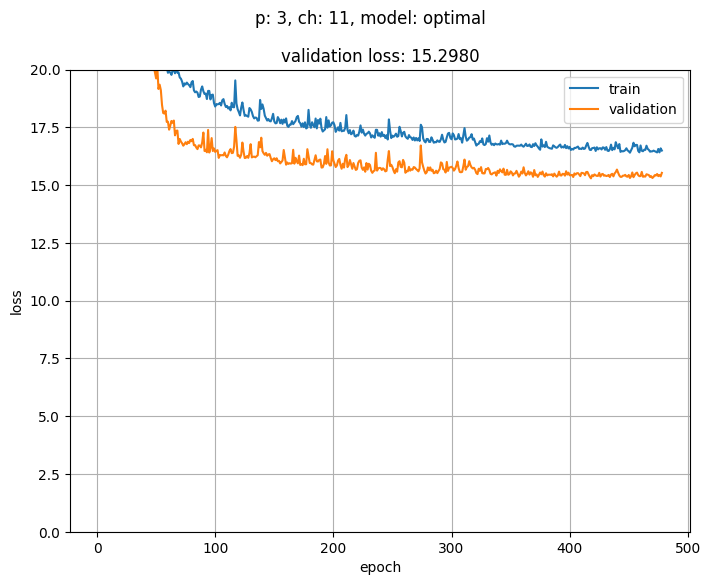

2/2 [==============================] - 0s 99ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


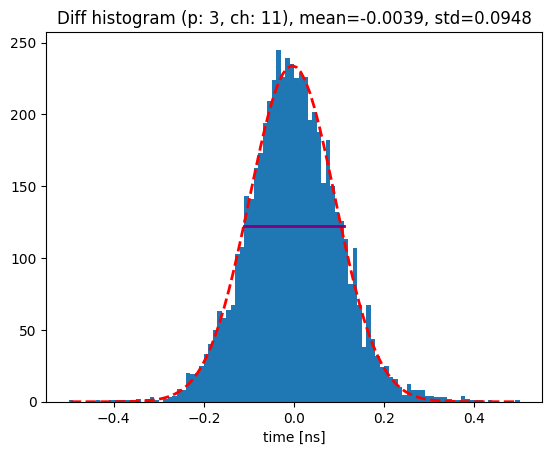

       CFD: 115.86 ps
   optimal: 94.80 ps (improvement: 18.18 %)


In [8]:
improvements = {}
for plane, channel in sorted(dataset.keys()):
    display(HTML(f'<h3>Plane: {plane}, channel: {channel}</h3>'))

    all_X, all_y = dataset[(plane, channel)][0], dataset[(plane, channel)][1]
    X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=TEST_SIZE,
                                                        random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    # CFD
    cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])
    y_pred_cfd = cfd.predict(X_TIME, X_test)
    std_cfd, _, _ = plot_difference_hist(y_test, y_pred_cfd, plane=plane, channel=channel, show=False)

    # Network
    Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

    model = optimal_model_builder_ch_2_11()
    try:
        history = train_model(model, f'optimal_{plane}_{channel}', X_train=X_train, y_train=Y_heatmap_train,
                              X_val=X_test, y_val=Y_heatmap_test, train=False)
    except (FileNotFoundError, NotFoundError):
        print(f'Could not find the model for ({plane}, {channel}). Setting train=False')
        history = train_model(model, f'optimal_{plane}_{channel}', X_train=X_train, y_train=Y_heatmap_train,
                              X_val=X_test, y_val=Y_heatmap_test, train=True)

    plot_history(history, f'p: {plane}, ch: {channel}, model: optimal', ymax=20)

    y_pred_model = model_predict(model, X_test)

    std_model, _, _ = plot_difference_hist(y_test, y_pred_model, plane=plane, channel=channel, show=True)

    print('=====================================================================')
    compare_results([std_model], ["optimal"], std_cfd)
    improvements[(plane, channel)] = (std_cfd, std_model, 1 - std_model / std_cfd)

In [9]:
print('Improvements:')
for (plane, channel), improv in improvements.items():
    print(
        f'({plane:>1}, {channel:>2}) CFD: {improv[0] * 1000:6.2f} ps, NN: {improv[1] * 1000:6.2f} ({improv[2] * 100:5.2f} %)')

Improvements:
(1,  2) CFD:  76.08 ps, NN:  67.70 (11.01 %)
(1, 11) CFD:  88.03 ps, NN:  80.22 ( 8.87 %)
(2,  2) CFD:  80.13 ps, NN:  69.42 (13.36 %)
(2, 11) CFD:  90.39 ps, NN:  85.02 ( 5.94 %)
(3,  2) CFD:  86.67 ps, NN:  76.14 (12.14 %)
(3, 11) CFD: 115.86 ps, NN:  94.80 (18.18 %)
